In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import io
import os
import tradingWithPython as twp
from tradingWithPython import sharpe # general trading toolbox functions
import pandas as pd # pandas time series library
from datetime import datetime
import quandl
quandl.ApiConfig.api_key = 'wxychbrgu7o7x3MRq4Hx'

C:\Users\chekitsch\Anaconda3\lib\site-packages\tradingWithPython\lib\cboe.py:11: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [169]:
sym1 = 'CHRIS/CME_NQ1'
#sym1 = 'CHRIS/CME_YM1'
#sym1 = 'CHRIS/CME_ES1'
sym2 = 'CHRIS/ICE_TF1'
#sym2 = 'CHRIS/CME_YM1'

price1 = None
price2 = None
while price1 is None:
    price1 = quandl.get(sym1)
while price2 is None:
    price2 = quandl.get(sym2)

In [170]:
''' conform nq index to tf '''
price1 = price1.reindex(price2.index)
pair = pd.DataFrame({'price1':price1.Settle,'price2':price2.Settle})

In [171]:
pair.pct_change().corr()

,price1,price2
price1,1.000000,0.858267
price2,0.858267,1.000000


In [172]:
twp.estimateBeta(pair['price1'],pair['price2'])

0.7125188303524902

In [173]:
''' build spread '''
pair['spread_pct'] = pair.price1.pct_change() - pair.price2.pct_change()
delta = 5   # x-day return
pair['spread_pct_N'] = pair.price1.pct_change(delta) - pair.price2.pct_change(delta)

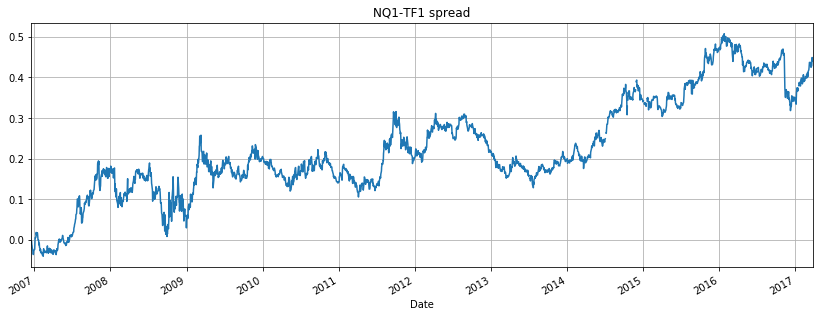

In [174]:
figsize(14,5)
title('{0}-{1} spread'.format(sym1[-3:],sym2[-3:]))
pair['spread_pct'].cumsum().plot(grid=True)

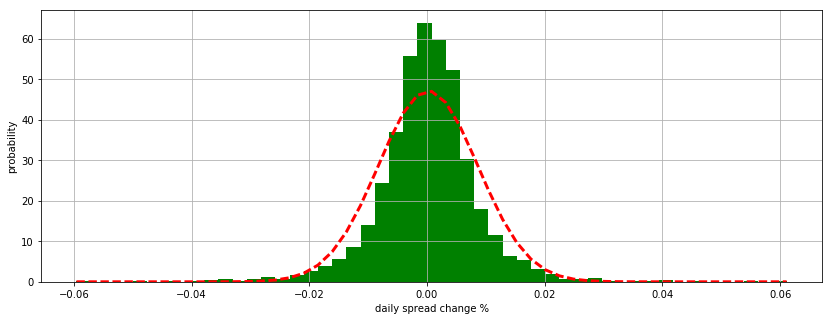

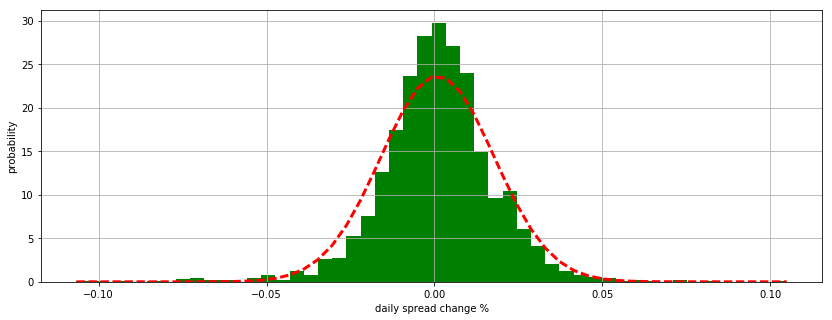

In [175]:
R = pair['spread_pct'].dropna()
n, bins ,patches = hist(R,50,normed=1,facecolor='green') # plot returns histogram with 50 bins
y = normpdf(bins,R.mean(),R.std())
plot(bins,y,'r--',linewidth=3)
xlabel('daily spread change %')
ylabel('probability')
grid(True)

figure()
R_nday = pair['spread_pct_N'].dropna()
n, bins ,patches = hist(R_nday,50,normed=1,facecolor='green') # plot returns histogram with 50 bins
y = normpdf(bins,R_nday.mean(),R_nday.std())
plot(bins,y,'r--',linewidth=3)
xlabel('daily spread change %')
ylabel('probability')
grid(True)

             z_score     cumRet         ma  momentum
Date                                                
2017-03-20  0.936028  42.895801  40.512180  2.383621
2017-03-21  1.666653  44.120204  40.520708  3.599495
2017-03-22  1.561908  44.858402  40.537251  4.321151
2017-03-23  0.366225  44.007904  40.552102  3.455802
2017-03-24  0.584342  44.164630  40.571153  3.593477


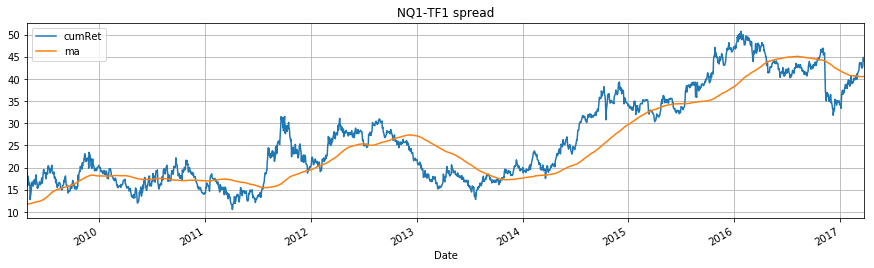

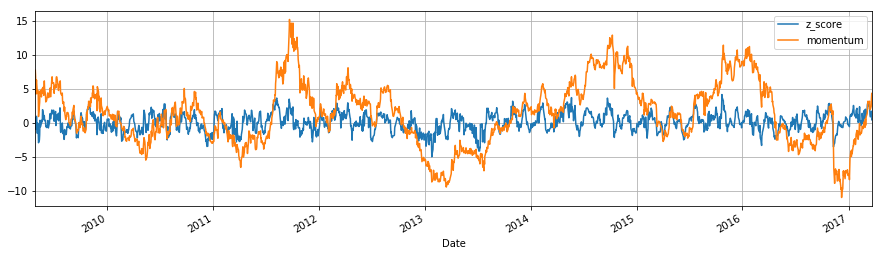

In [178]:
indicators = pd.DataFrame(index = R.index) #prepare indicators DataFrame
delta = 10
R_nday = pair.price1.pct_change(delta) - pair.price2.pct_change(delta)
R_nday = R_nday.dropna()

indicators['z_score'] = R_nday/R_nday.rolling(window=25).std() # current day return z-score
indicators['cumRet'] = 100 * R.cumsum() # total sum of returns, which is a sythetic price
indicators['ma'] = indicators['cumRet'].rolling(window=200).mean() #moving average of synthetic price
indicators['momentum'] = indicators['cumRet']-indicators['ma'] # difference between synth. 
                                                                #price and ma, gives indication of momentum strength
print (indicators.tail(5))

figsize(15,4)
indicators[['cumRet','ma']].tail(2000).plot(grid=True)
title('{0}-{1} spread'.format(sym1[-3:],sym2[-3:]))
figure()
indicators[['z_score','momentum']].tail(2000).plot(grid=True)

In [144]:
def backtest(ret_nday, ret_1d, window=15, ma_thresh = 0.6, ma_window=50, z_enter=2.5, z_enter2=0, z_exit=1.75):
    """
    Parameters
    ret_nday: n-day rolling returns (designed to catch big but gradual deviation from mean)
    ret_1d: 1-day return used to calculate synthetic price
    window: used to calculate z-score (entry signal) on n-day rolling returns
    ma_thresh: additional entry signal to complement z-score; difference between synth. price and its moving avg
    z_enter: threshold to initiate position
    z_enter2: default = 0 (i.e. off), add to initial position
    z_exit: target level (exit signal) used to close position
    
    """
    
    price = 100 * ret_1d.cumsum()  # synthetic price
        
    #----indicators
    z_score = ret_nday / ret_nday.rolling(window=window).std()  # current day z-score
    aboveAverage = (price - price.rolling(window=ma_window).mean()) > ma_thresh # is the price above average by 0.5? T/F, window size fixed
    belowAverage = (price - price.rolling(window=ma_window).mean()) < -ma_thresh # is the price below average by 0.5? T/F, window size fixed

    """ backtest with entering on a given z_score """
    pos = pd.Series(index = ret_nday.index, data = 0)  # position vector

    pos[(aboveAverage & (z_score > z_enter))] = -1 # short position
    pos[(belowAverage & (z_score < -z_enter))] = 1 # long position
    if z_enter2:                                    # double down if z-score hits 2nd z-entry
        pos[(aboveAverage & (z_score > z_enter2))] = -2 # short position
        pos[(belowAverage & (z_score < -z_enter2))] = 2 # long position

    for i,p in enumerate(pos):
        if i > 0 and pos[i] <= pos[i-1] and pos[i-1] > 0 and z_score[i] < z_exit:  # if long, and z_score has not hit target, hold
            pos[i] = pos[i-1]
        elif i > 0 and pos[i] >= pos[i-1] and pos[i-1] < 0 and z_score[i] > -z_exit:  # if short position and z_score has not hit target, keep shorting
            pos[i] = pos[i-1]
            
    #print (pos.value_counts())
    pos = pos.shift(1) # todays position has effect on tomorrows return. Shift 1 day into future.
    pnl = ret_1d*pos # daily pnl 
    return pd.DataFrame({'pnl':pnl,'pos':pos, 'z_score':z_score})


** ES - YM **

In [167]:
pair['spread_pct'] = pair.price1.pct_change() - pair.price2.pct_change()
#delta = 20   # x-day return
#pair['spread_pct_N'] = pair.price1.pct_change(delta) - pair.price2.pct_change(delta)
#df = backtest(pair['spread_pct_N'].dropna(), pair['spread_pct'].dropna(), window=45, ma_thresh = 0.5, ma_window=100, z_enter=2.5, z_enter2=3.6, z_exit=1.5)

pair['spread_pct'] = pair.price1.pct_change() - pair.price2.pct_change()
delta = 10   # x-day return
pair['spread_pct_N'] = pair.price1.pct_change(delta) - pair.price2.pct_change(delta)
df = backtest(pair['spread_pct_N'].dropna(), pair['spread_pct'].dropna(), window=25, ma_thresh = 0.5, ma_window=200, z_enter=2.1, z_enter2=3.3, z_exit=1.3)

Sharpe since inception:  -0.04930978658
Sharpe trailing 1900 days: -0.08207275794478422
1900-day P&L: -0.04936853955649101


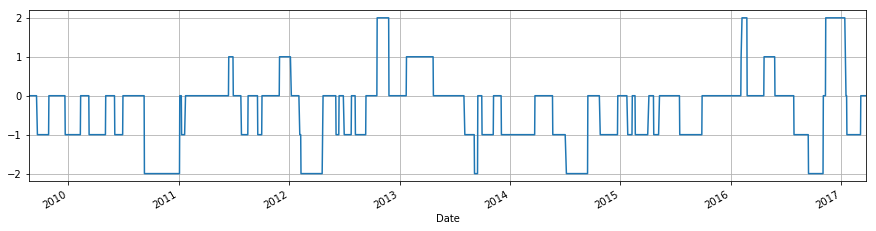

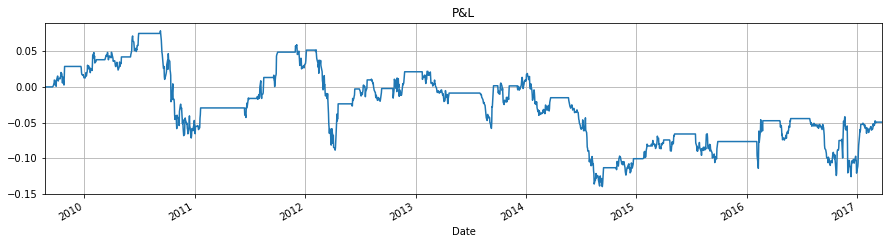

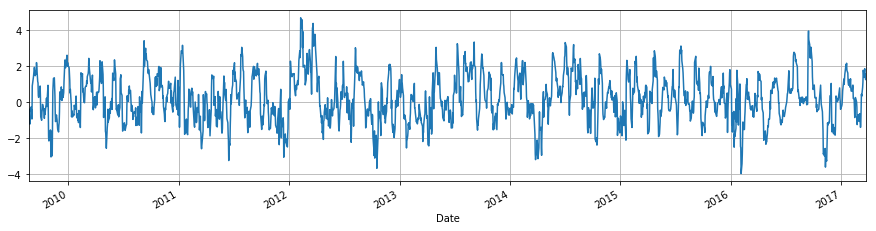

In [168]:
period = 1900
figsize(15,3.5)
df.pos.tail(period).plot(grid=True)
#title('Position')
figure()
df.pnl.tail(period).cumsum().plot(grid=True)
title('P&L')
figure()
df.z_score.tail(period).plot(grid=True)
print ('Sharpe since inception: ', twp.sharpe(df.pnl))
print ('Sharpe trailing {0} days: {1}'.format(period, twp.sharpe(df.pnl.tail(period))) )
print ('{0}-day P&L: {1}'.format(period, df.pnl.tail(period).cumsum()[-1]))

** NQ - TF **

In [179]:
pair['spread_pct'] = pair.price1.pct_change() - pair.price2.pct_change()
delta = 20   # x-day return
pair['spread_pct_N'] = pair.price1.pct_change(delta) - pair.price2.pct_change(delta)
df = backtest(pair['spread_pct_N'].dropna(), pair['spread_pct'].dropna(), window=15, ma_thresh = 0.5, ma_window=160, z_enter=2.4, z_enter2=3.3, z_exit=1.5)

#delta = 10   # x-day return
#pair['spread_pct_N'] = pair.price1.pct_change(delta) - pair.price2.pct_change(delta)
#df = backtest(pair['spread_pct_N'].dropna(), pair['spread_pct'].dropna(), window=15, ma_thresh = 0.5, ma_window=160, z_enter=2.3, z_enter2=3.2, z_exit=1.7)

Sharpe since inception:  0.0195237745575
Sharpe trailing 2400 days: 0.04217773851843542
2400-day P&L: 0.08459937159659048


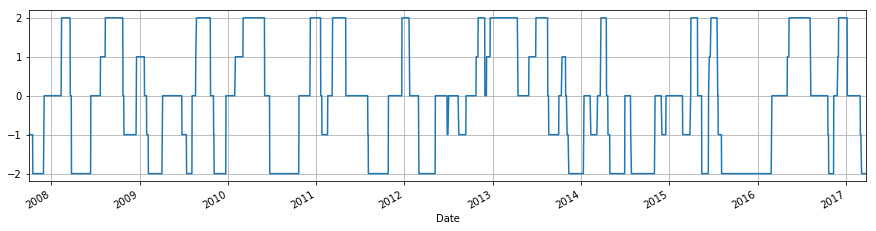

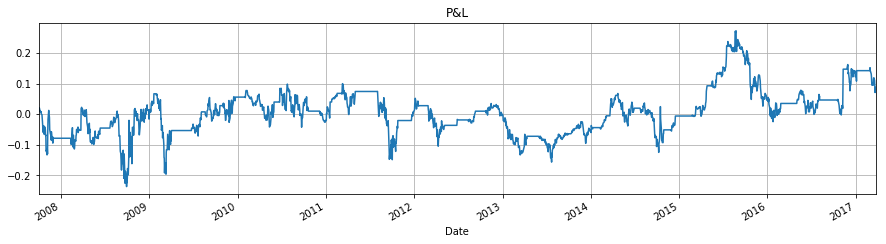

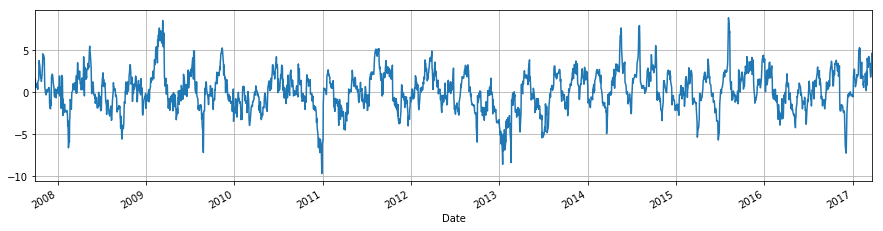

In [180]:
period = 2400
figsize(15,3.5)
df.pos.tail(period).plot(grid=True)
#title('Position')
figure()
df.pnl.tail(period).cumsum().plot(grid=True)
title('P&L')
figure()
df.z_score.tail(period).plot(grid=True)
print ('Sharpe since inception: ', twp.sharpe(df.pnl))
print ('Sharpe trailing {0} days: {1}'.format(period, twp.sharpe(df.pnl.tail(period))) )
print ('{0}-day P&L: {1}'.format(period, df.pnl.tail(period).cumsum()[-1]))

## Optimize z-entry and z-exit ##

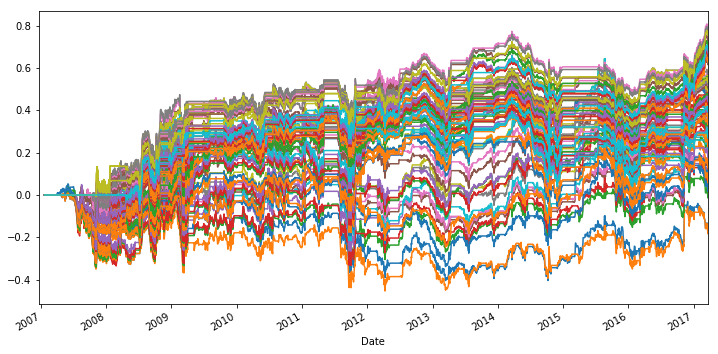

In [183]:
""" optimize and optionally plot pnl """
        
window = np.arange(10,50,5)  # backtest for z-entry 0.5 to 3, steps of 0.1
ma_window = np.arange(60,260,20)  # backtest for z-exit -1.0 to 0.5, steps of 0.1
sharpe = np.zeros((len(window), len(ma_window)))
        
for i,win1 in enumerate(window):
    for j,win2 in enumerate(ma_window):
        df = backtest(pair['spread_pct_N'].dropna(), pair['spread_pct'].dropna(), window=win1, ma_thresh = 0.5, ma_window=win2, z_enter=2.3, z_enter2=3.7, z_exit=1.8)
        sharpe[i,j] = twp.sharpe(df.pnl)
        df.pnl.cumsum().plot()

i:  45
j:  180


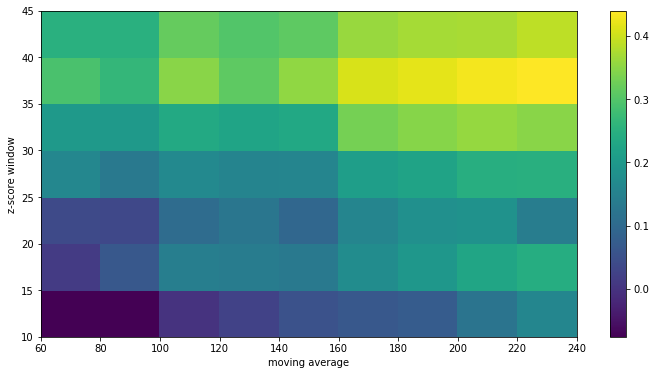

In [184]:
figsize(12,6)
pcolor(ma_window, window, sharpe)
ylabel('z-score window')
xlabel('moving average');
colorbar();

i,j = np.unravel_index(sharpe.argmax(), sharpe.shape)
print ("i: ", window[i])
print ("j: ", ma_window[j])